In [1]:
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
import sklearn
import matplotlib.pyplot as pl
import numpy as np
from tqdm import tqdm
import keras
import pandas as pd
import loadnhanes
import lifelines
import scipy

Using TensorFlow backend.


In [2]:
X,y = loadnhanes._load()

# clean up a bit
for c in X.columns:
    if c.endswith("_isBlank"):
        del X[c]
X["bmi"] = 10000 * X["weight"].values.copy() / (X["height"].values.copy() * X["height"].values.copy())
del X["weight"]
del X["height"]
del X["urine_hematest_isTrace"] # would have no variance in the strain set
del X["SGOT_isBlankbutapplicable"] # would have no variance in the strain set
del X["calcium_isBlankbutapplicable"] # would have no variance in the strain set
del X["uric_acid_isBlankbutapplicable"] # would only have one true value in the train set
del X["urine_hematest_isVerylarge"] # would only have one true value in the train set
del X["total_bilirubin_isBlankbutapplicable"] # would only have one true value in the train set
del X["alkaline_phosphatase_isBlankbutapplicable"] # would only have one true value in the train set
del X["hemoglobin_isUnacceptable"] # redundant with hematocrit_isUnacceptable
rows = np.where(np.invert(np.isnan(X["systolic_blood_pressure"]) | np.isnan(X["bmi"])))[0]
X = X.iloc[rows,:]
y = y[rows]
# Convert to binary prediction of mortality
y = y > 0

name_map = {
    "sex_isFemale": "Sex",
    "age": "Age",
    "systolic_blood_pressure": "Systolic blood pressure",
    "bmi": "BMI",
    "white_blood_cells": "White blood cells", # (mg/dL)
    "sedimentation_rate": "Sedimentation rate",
    "serum_albumin": "Blood albumin",
    "alkaline_phosphatase": "Alkaline phosphatase",
    "cholesterol": "Total cholesterol",
    "physical_activity": "Physical activity",
    "hematocrit": "Hematocrit",
    "uric_acid": "Uric acid",
    "red_blood_cells": "Red blood cells",
    "urine_albumin_isNegative": "Albumin present in urine",
    "serum_protein": "Blood protein"
}
mapped_feature_names = list(map(lambda x: name_map.get(x, x), X.columns))

# split by patient id
pids = np.unique(X.index.values)
train_pids,test_pids = train_test_split(pids, random_state=0)
strain_pids,valid_pids = train_test_split(train_pids, random_state=0)

# find the indexes of the samples from the patient ids
train_inds = np.where([p in train_pids for p in X.index.values])[0]
strain_inds = np.where([p in strain_pids for p in X.index.values])[0]
valid_inds = np.where([p in valid_pids for p in X.index.values])[0]
test_inds = np.where([p in test_pids for p in X.index.values])[0]

# create the split datasets
X_train = X.iloc[train_inds,:]
X_strain = X.iloc[strain_inds,:]
X_valid = X.iloc[valid_inds,:]
X_test = X.iloc[test_inds,:]
y_train = y[train_inds]
y_strain = y[strain_inds]
y_valid = y[valid_inds]
y_test = y[test_inds]

# mean impute for linear and deep models
imp = Imputer()
imp.fit(X_strain)
X_strain_imp = imp.transform(X_strain)
X_train_imp = imp.transform(X_train)
X_valid_imp = imp.transform(X_valid)
X_test_imp = imp.transform(X_test)
X_imp = imp.transform(X)

# standardize
scaler = StandardScaler()
scaler.fit(X_strain_imp)
X_strain_imp = scaler.transform(X_strain_imp)
X_train_imp = scaler.transform(X_train_imp)
X_valid_imp = scaler.transform(X_valid_imp)
X_test_imp = scaler.transform(X_test_imp)
X_imp = scaler.transform(X_imp)

[-21.08333333 -21.08333333 -21.08333333 ... -17.08333333 -17.08333333
 -17.08333333]
number of people surviving  9622
number of people not surviving  4785


/homes/gws/hughchen/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(100, input_dim=X_strain_imp.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(X_strain_imp, y_strain, epochs=50, batch_size=128,
                    validation_data=(X_valid_imp, y_valid))
score = model.evaluate(X_test_imp, y_test, batch_size=128)
print("Test loss: {}, Test acc: {}".format(score[0],score[1]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 8023 samples, validate on 2675 samples
Epoch 1/50
8023/8023 [==============================] - 1s 97us/step - loss: 0.7000 - acc: 0.6256 - val_loss: 0.5885 - val_acc: 0.6856
Epoch 2/50
8023/8023 [==============================] - 0s 51us/step - loss: 0.6041 - acc: 0.6828 - val_loss: 0.5112 - val_acc: 0.7742
Epoch 3/50
8023/8023 [==============================] - 0s 51us/step - loss: 0.5573 - acc: 0.7199 - val_loss: 0.4890 - val_acc: 0.7933
Epoch 4/50
8023/8023 [==============================] - 0s 52us/step - loss: 0.5178 - acc: 0.7626 - val_loss: 0.4710 - val_acc: 0.8082
Epoch 5/50
8023/8023 [==============================] - 0s 52us/step - loss: 0.4976 - acc: 0.7815 - val_loss: 0.4559 - val_acc: 0.8164
Epoch 6/50
8023/8023 [====================

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 6, 2
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [22]:
import shap
stepsize = 1000; n = X_strain_imp.shape[0]
print("***Average Baseline***")
background = X_strain_imp[np.random.choice(n,stepsize,replace=False)]
explainer = shap.DeepExplainer(model, background)
sv = explainer.shap_values(X_strain_imp)

***Average Baseline***


In [23]:
(model.predict(X_strain_imp)-model.predict(background).mean())[:,0]

array([-0.24785495,  0.18079779, -0.1731388 , ...,  0.1680592 ,
       -0.14733501, -0.25653276], dtype=float32)

In [24]:
sv[0][0].mean(1)

IndexError: tuple index out of range

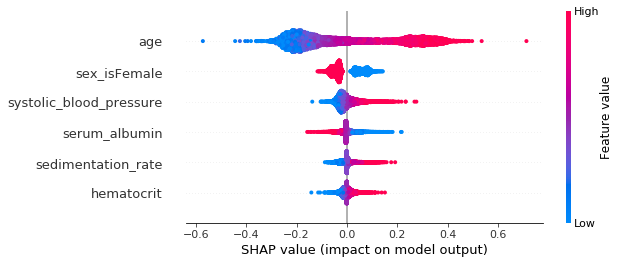

In [7]:
shap.summary_plot(sv[0], features=X_strain_imp, feature_names=list(X.columns.values), max_display=6)

In [9]:
import shap
stepsize = 1000; n = X_strain_imp.shape[0]
print("***Average Baseline***")
background = X_strain_imp[np.random.choice(n,stepsize,replace=False)]
explainer = shap.GradientExplainer(model, background)
sv = explainer.shap_values([X_strain_imp])

***Average Baseline***


In [21]:
(model.predict(X_strain_imp)-model.predict(background).mean())[:,0]

array([-0.26146537,  0.16718736, -0.18674922, ...,  0.15444878,
       -0.16094543, -0.27014318], dtype=float32)

In [15]:
sv[0][0].mean(1)

array([-0.0035743 ,  0.00266225, -0.00256349, ...,  0.00165983,
       -0.00235164, -0.00347093])

### Old with old background

In [150]:
sX = X.iloc[strain_inds,:]
X_strain_imp_subset = X_strain_imp[sX.age > 60] # Older subjects
foreground_ind = np.random.choice(X_strain_imp_subset.shape[0],1)[0]
foreground_ind = 2453
foreground = X_strain_imp_subset[foreground_ind:foreground_ind+1,:]

In [151]:
old_sX = sX[sX.age > 60]
old_sX.iloc[foreground_ind,:]

sex_isFemale                                 False
age                                             67
physical_activity                                3
serum_albumin                                  NaN
alkaline_phosphatase                            47
alkaline_phosphatase_isUnacceptable          False
alkaline_phosphatase_isTestnotdone           False
SGOT                                          2.06
SGOT_isUnacceptable                          False
SGOT_isTestnotdone                           False
BUN                                             13
BUN_isUnacceptable                           False
BUN_isTestnotdone                            False
calcium                                          9
calcium_isUnacceptable                       False
calcium_isTestnotdone                        False
creatinine                                       1
creatinine_isUnacceptable                    False
creatinine_isTestnotdone                     False
potassium                      

***Average Baseline***


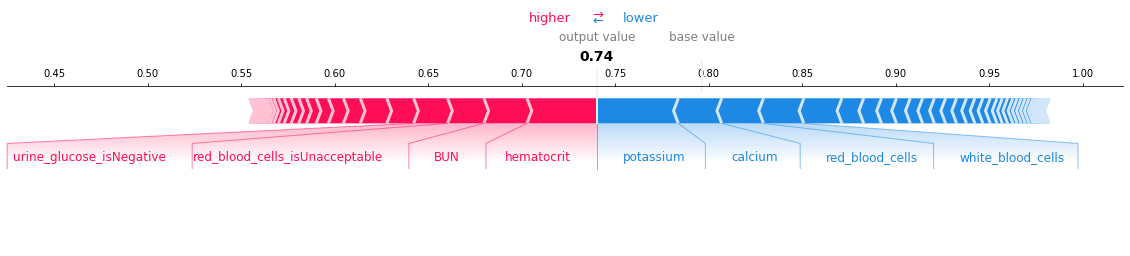

In [164]:
stepsize = 1000
print("***Average Baseline***")
# n = X_strain_imp_subset.shape[0]
# background = X_strain_imp_subset[np.random.choice(n,stepsize,replace=False)]
n = X_strain_imp_subset[X_strain_imp_subset[:,0]<0].shape[0]
background = X_strain_imp_subset[X_strain_imp_subset[:,0]<0][np.random.choice(n,stepsize,replace=False)]
explainer = shap.DeepExplainer(model, background)
sv = explainer.shap_values(foreground)
# shap.initjs()

fig = shap.force_plot(explainer.expected_value, sv[0], features=list(X.columns.values),
                      matplotlib=True,show=False)
fig.savefig("fig/individual{}_oldmalebackground.pdf".format(foreground_ind))

In [165]:
model.predict(background).mean()

0.79640734

***Average Baseline***


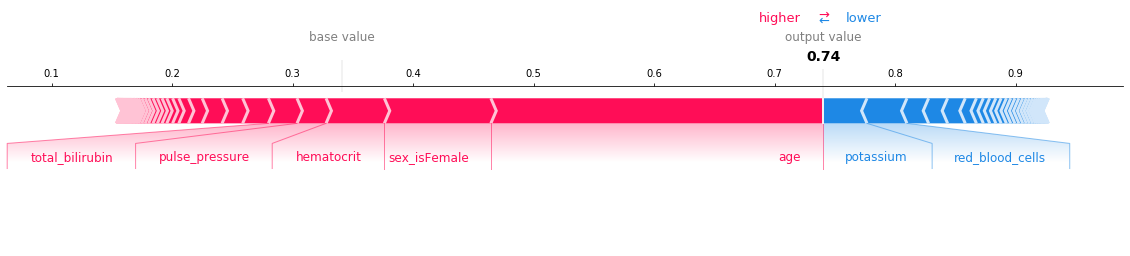

In [163]:
stepsize = 1000; n = X_strain_imp.shape[0]
print("***Average Baseline***")
background = X_strain_imp[np.random.choice(n,stepsize,replace=False)]
explainer = shap.DeepExplainer(model, background)
sv = explainer.shap_values(foreground)
# shap.initjs()
fig = shap.force_plot(explainer.expected_value, sv[0], features=list(X.columns.values),
                      matplotlib=True,show=False)
fig.savefig("fig/individual{}_allbackground.pdf".format(foreground_ind))

In [155]:
model.predict(background).mean()

0.3409441

### Old with all background

In [ ]:
X_strain_imp_f = X_strain_imp[X.iloc[strain_inds,:]["age"] > 60] # Older subjects

stepsize = 1000; n = X_strain_imp_f.shape[0]
print("***Average Baseline***")
background = X_strain_imp[np.random.choice(n,stepsize,replace=False)]
explainer = shap.DeepExplainer(model, background)
sv = explainer.shap_values(X_strain_imp_f)
shap.summary_plot(sv[0], features=X_strain_imp_f, feature_names=list(X.columns.values), max_display=15)